# Polymer Atmospheric Correction

The Polymer algorithm has been chosen for atmospheric correction. Polymer supports `.nc` files produced from SNAP to be used as input.

## Setup

In [1]:
import os
import sys

In [2]:
from contextlib import redirect_stdout, redirect_stderr

In [3]:
import logging

In [4]:
import numpy as np
import pandas as pd

In [5]:
import xarray as xr

In [6]:
import matplotlib.pyplot as plt

In [7]:
sys.path.append('/home/chanon/project/packages/polymer')

In [8]:
from polymer.main import run_atm_corr
from polymer.level1_netcdf import Level1_NETCDF
from polymer.level2_nc import Level2_NETCDF
from polymer.ancillary import Ancillary_NASA

In [9]:
DATA_DIR = '../data/'
FIGURES_DIR = '../saved_figures/'

In [10]:
results_dir = os.path.join(DATA_DIR, "s2_processed")

In [11]:
dir_content = os.listdir(results_dir)

## Example

In [8]:
fn = '30UUA'

In [9]:
level1_file = os.path.join(results_dir, f'{fn}/subset-{fn}.nc')
output_file = os.path.join(results_dir, f'{fn}/polymer-{fn}.nc')
landmask_file = os.path.join(results_dir, f'{fn}/idepix-{fn}.nc')

In [39]:
flags_ds = xr.open_dataset(landmask_file)

In [40]:
land_mask = (flags_ds['pixel_classif_flags'].astype('int32') & 2**10) != 0

In [41]:
flags_ds.close()

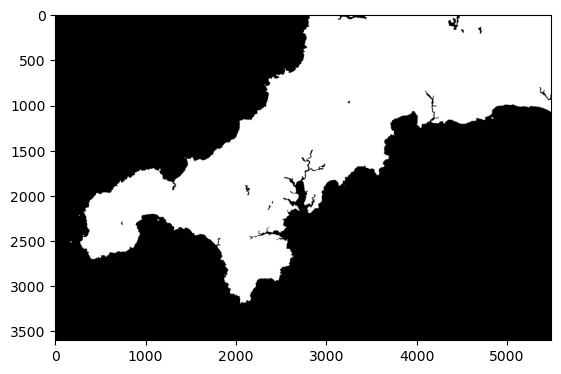

In [42]:
plt.imshow(land_mask, cmap='gray')

In [10]:
s2_ds = xr.open_dataset(level1_file)

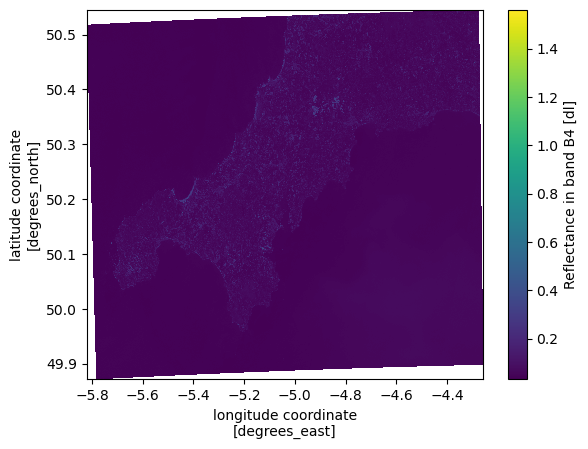

In [19]:
s2_ds['B4'].plot(x='lon', y='lat')

In [11]:
rgb_img = np.dstack((s2_ds.B4.data, s2_ds.B3.data, s2_ds.B2.data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12719999999999998..6.2452].


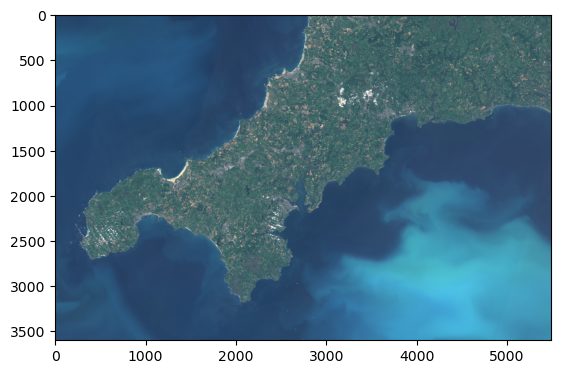

In [12]:
plt.imshow(rgb_img*4)
plt.savefig(os.path.join(FIGURES_DIR, 's2_example'))

In [23]:
level1 = Level1_NETCDF(
    filename=level1_file,
    landmask=land_mask,
    ancillary=Ancillary_NASA()
)

MSI product, size is 3599x5490


In [24]:
level2 = Level2_NETCDF(
    filename=output_file
)

In [26]:
run_atm_corr(
    level1,
    level2,
    multiprocessing=-1
)

Starting processing at 2025-04-21 20:06:25.370377
Initializing output file "../data/s2_processed/30UUA/polymer-30UUA.nc"
Processing block: size (500, 400), offset (0, 0)
Processing block: size (500, 400), offset (0, 400)
Processing block: size (500, 400), offset (0, 800)
Processing block: size (500, 400), offset (0, 1200)
Processing block: size (500, 400), offset (0, 1600)
Processing block: size (500, 400), offset (0, 2000)
Processing block: size (500, 400), offset (0, 2400)
Processing block: size (500, 400), offset (0, 2800)
Processing block: size (500, 400), offset (0, 3200)
Processing block: size (500, 400), offset (0, 3600)
Processing block: size (500, 400), offset (0, 4000)
Processing block: size (500, 400), offset (0, 4400)
Processing block: size (500, 400), offset (0, 4800)
Processing block: size (500, 290), offset (0, 5200)
Processing block: size (500, 400), offset (500, 0)
Processing block: size (500, 400), offset (500, 400)
Processing block: size (500, 400), offset (500, 800)

In [30]:
l2_ds = xr.open_dataset(output_file)

In [31]:
l2_ds

<xarray.Dataset> Size: 2GB
Dimensions:    (height: 3599, width: 5490)
Dimensions without coordinates: height, width
Data variables: (12/17)
    latitude   (height, width) float64 158MB ...
    longitude  (height, width) float64 158MB ...
    bitmask    (height, width) float32 79MB ...
    Rnir       (height, width) float32 79MB ...
    Rgli       (height, width) float32 79MB ...
    logchl     (height, width) float32 79MB ...
    ...         ...
    Rw705      (height, width) float32 79MB ...
    Rw740      (height, width) float32 79MB ...
    Rw783      (height, width) float32 79MB ...
    Rw842      (height, width) float32 79MB ...
    Rw865      (height, width) float32 79MB ...
    Rw1610     (height, width) float32 79MB ...
Attributes: (12/57)
    sensor:                MSI
    dir_static:            /home/chanon/project/packages/polymer/auxdata/static
    dir_common:            /home/chanon/project/packages/polymer/auxdata/stat...
    thres_Rcloud:          0.2
    thres_Rcloud_std:      0.04
    force_initialization:  False
    ...                    ...
    processing_duration:   0:08:58.516843
    l1_filename:           ../data/s2_processed/30UUA/subset-30UUA.nc
    start_time:            2020-06-23 11:21:19
    stop_time:             2020-06-23 11:21:19
    l2_filename:           ../data/s2_processed/30UUA/polymer-30UUA.nc
    l2_format:             NETCDF4_CLASSIC

In [33]:
l2_img = np.dstack((l2_ds.Rw665.data, l2_ds.Rw560.data, l2_ds.Rw490.data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49388957..11.810299].


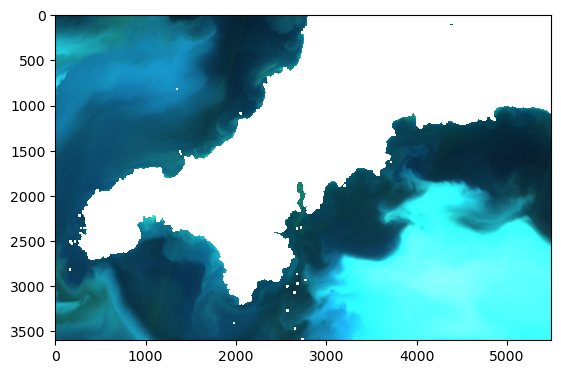

In [34]:
plt.imshow(l2_img * 15)

## Loop over tiles

In [12]:
log_file = 'polymer_run.log'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler(log_file, mode='a')]
)
logger = logging.getLogger(__name__)

In [ ]:
for fn in dir_content:
    fp = os.path.join(results_dir, fn)  # fn is a tileId

    if fn != '.ipynb_checkpoints' and os.path.isdir(fp):
        # Get S2 subset from SNAP output
        level1_file = os.path.join(results_dir, f'{fn}/subset-{fn}.nc')
        output_file = os.path.join(results_dir, f'{fn}/polymer-{fn}.nc')
        landmask_file = os.path.join(results_dir, f'{fn}/idepix-{fn}.nc')

        try:
            logger.info(f"[{fn}] Loading land mask file: {landmask_file}")
            with xr.open_dataset(landmask_file) as ds:
                # land mask is 11th bit
                land_mask = (ds['pixel_classif_flags'].astype('int32') & 2**10) != 0
    
            # Process subset with Polymer
            
            logger.info(f"[{fn}] Loading Level 1: {level1_file}")    
            level1 = Level1_NETCDF(
                filename=level1_file,
                landmask=land_mask,
                ancillary=Ancillary_NASA()
            )
    
            level2 = Level2_NETCDF(
                filename=output_file
            )

            print(f"[{fn}] Running Polymer...")
            logger.info(f"[{fn}] Running Polymer atmospheric correction...")

            with open(log_file, 'a') as f:
                with redirect_stdout(f), redirect_stderr(f):
                    run_atm_corr(
                        level1,
                        level2,
                        multiprocessing=-1
                    )
            logger.info(f"[{fn}] Atmospheric correction completed. Output saved to {output_file}")
        except Exception as e:
            print(f"[{fn}] Error processing: {e}")

MSI product, size is 5001x4632
[30VWL] Running Polymer...
[30VWL] Error processing: File "../data/s2_processed/30VWL/polymer-30VWL.nc" exists
MSI product, size is 5490x4337
[32UNG] Running Polymer...
MSI product, size is 3599x5490
[30UUA] Running Polymer...
[30UUA] Error processing: File "../data/s2_processed/30UUA/polymer-30UUA.nc" exists
MSI product, size is 5490x5490
Trying to download https://oceandata.sci.gsfc.nasa.gov/cgi/getfile/GMAO_MERRA2.20200807T100000.MET.nc ... 
Trying to download https://oceandata.sci.gsfc.nasa.gov/cgi/getfile/GMAO_MERRA2.20200807T110000.MET.nc ... 


2025-04-21 21:21:38 URL:https://oceandata.sci.gsfc.nasa.gov/getfile/GMAO_MERRA2.20200807T100000.MET.nc [3098455/3098455] -> "/home/chanon/project/packages/polymer/auxdata/ancillary/METEO/2020/220/GMAO_MERRA2.20200807T100000.MET.nc.tmp" [1]
2025-04-21 21:21:43 URL:https://oceandata.sci.gsfc.nasa.gov/getfile/GMAO_MERRA2.20200807T110000.MET.nc [3100658/3100658] -> "/home/chanon/project/packages/polymer/auxdata/ancillary/METEO/2020/220/GMAO_MERRA2.20200807T110000.MET.nc.tmp" [1]


[32UPF] Running Polymer...
[32UPF] Error processing: index -9223372036854775808 is out of bounds for axis 1 with size 37
Processing block: size (500, 400), offset (4000, 3600)
MSI product, size is 5490x5490
Trying to download https://oceandata.sci.gsfc.nasa.gov/cgi/getfile/GMAO_MERRA2.20200601T110000.MET.nc ... 
Processing block: size (500, 400), offset (4000, 4000)
Processing block: size (500, 400), offset (4000, 4400)
Processing block: size (500, 400), offset (4000, 4800)
Processing block: size (500, 290), offset (4000, 5200)
Processing block: size (500, 400), offset (4500, 0)
Processing block: size (500, 400), offset (4500, 400)
Processing block: size (500, 400), offset (4500, 800)
Processing block: size (500, 400), offset (4500, 1200)
Trying to download https://oceandata.sci.gsfc.nasa.gov/cgi/getfile/GMAO_MERRA2.20200601T120000.MET.nc ... 


2025-04-21 21:33:23 URL:https://oceandata.sci.gsfc.nasa.gov/getfile/GMAO_MERRA2.20200601T110000.MET.nc [3164065/3164065] -> "/home/chanon/project/packages/polymer/auxdata/ancillary/METEO/2020/153/GMAO_MERRA2.20200601T110000.MET.nc.tmp" [1]


Processing block: size (500, 400), offset (4500, 1600)
Processing block: size (500, 400), offset (4500, 2000)
Processing block: size (500, 400), offset (4500, 2400)


2025-04-21 21:33:28 URL:https://oceandata.sci.gsfc.nasa.gov/getfile/GMAO_MERRA2.20200601T120000.MET.nc [3161328/3161328] -> "/home/chanon/project/packages/polymer/auxdata/ancillary/METEO/2020/153/GMAO_MERRA2.20200601T120000.MET.nc.tmp" [1]


[30UUF] Running Polymer...


## Load and plot

In [7]:
l2_ds = xr.open_dataset(os.path.join(results_dir, '30UUA/polymer-30UUA.nc'))

In [8]:
l2_img = np.dstack((l2_ds.Rw665.data, l2_ds.Rw560.data, l2_ds.Rw490.data))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49388957..11.810299].


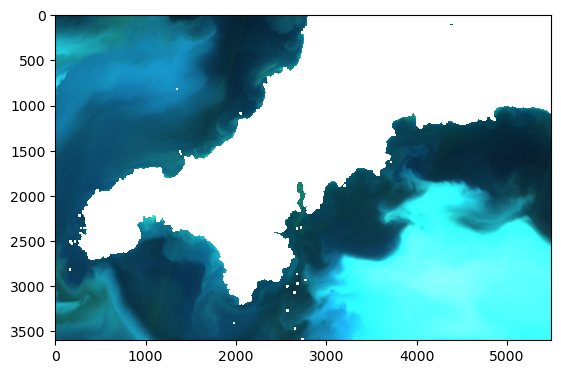

In [9]:
plt.imshow(l2_img * 15)
plt.savefig(os.path.join(FIGURES_DIR, 'polymer_example'))